   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.4 MB/s eta 0:00:00
                            content sentiment
0                  Neutral feelings   neutral
1             Worst experience ever  negative
2  Totally exceeded my expectations  positive
3              Absolutely fantastic  positive
4                    Superb quality  positive
sentiment
neutral     334
negative    333
positive    333
Name: count, dtype: int64

Model: Random Forest
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        63

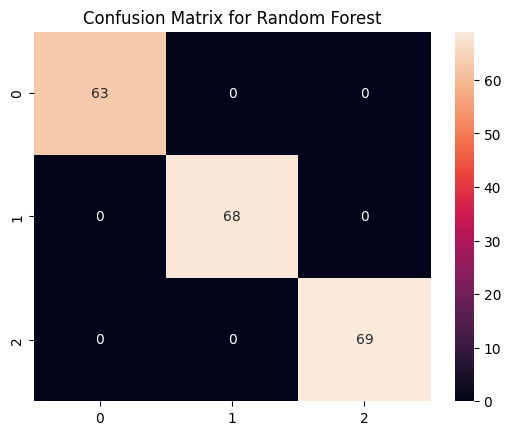


Model: Logistic Regression
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        63
     neutral       1.00      1.00      1.00        68
    positive       1.00      1.00      1.00        69

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



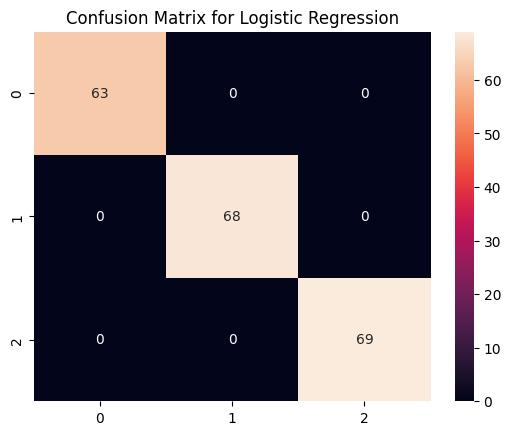


Model: SVM
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        63
     neutral       1.00      1.00      1.00        68
    positive       1.00      1.00      1.00        69

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



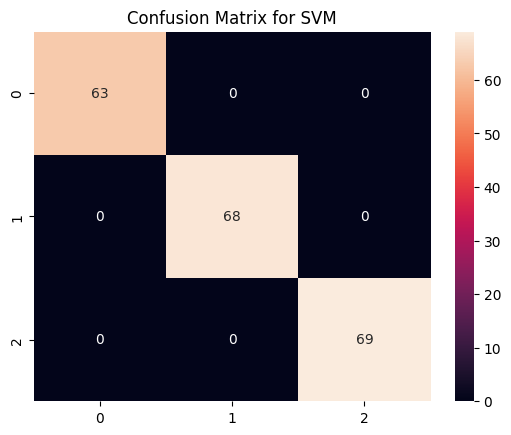

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4f6d47c501e6bbf911.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
# Install Gradio first
!pip install gradio

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import gradio as gr

# Generate synthetic dataset
np.random.seed(42)

positive_phrases = [
    "I love this!", "This is amazing", "Absolutely fantastic", "Best experience ever",
    "Totally exceeded my expectations", "Highly recommend this", "So happy with it",
    "Will buy again", "Five stars", "Superb quality"
]

negative_phrases = [
    "I hate this", "This is terrible", "Worst experience ever", "Very disappointed",
    "Not worth the money", "Will never buy again", "One star", "Poor quality",
    "Extremely bad", "Do not recommend"
]

neutral_phrases = [
    "It's okay", "Not bad", "Could be better", "Average experience",
    "Meh, it's fine", "Nothing special", "So-so", "Neutral feelings",
    "Neither good nor bad", "Just okay"
]

def generate_samples(phrases, label, n):
    samples = np.random.choice(phrases, n)
    return pd.DataFrame({'content': samples, 'sentiment': label})

n_samples = 333  # roughly equal split

df_pos = generate_samples(positive_phrases, 'positive', n_samples)
df_neg = generate_samples(negative_phrases, 'negative', n_samples)
df_neu = generate_samples(neutral_phrases, 'neutral', 334)  # to make total 1000

df = pd.concat([df_pos, df_neg, df_neu]).sample(frac=1).reset_index(drop=True)  # shuffle

# Initial exploration
print(df.head())
print(df['sentiment'].value_counts())

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

df['clean_text'] = df['content'].apply(clean_text)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and evaluation
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=200),
    'SVM': SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

# Save the best model (Random Forest here)
best_model = models['Random Forest']
joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# Gradio interface for prediction
def predict_emotion(text):
    model = joblib.load('sentiment_model.pkl')
    vect = joblib.load('vectorizer.pkl')
    cleaned = clean_text(text)
    vectorized = vect.transform([cleaned]).toarray()
    prediction = model.predict(vectorized)[0]
    return prediction

interface = gr.Interface(
    fn=predict_emotion,
    inputs="text",
    outputs="text",
    title="Social Media Emotion Predictor",
    description="Enter a social media post to detect the underlying emotion."
)

interface.launch()